# Исследование надёжности заёмщиков

Предполагаемый заказчик исследования - кредитный отдел некоего банка. Необходимо провести предварительную очистку датасета, провести анализ заёмщиков и в итоге выдать маску клиента, который с наибольшей вероятностью не будет задерживать выплаты

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Описание используемого датасета

Столбец  | Содержащиеся данные | Тип данных
------------- | ------------- | -----------------
children  | Число детей в семье | int
days_employed  | Общий трудовой стаж в днях | float
dob_years | Возраст клиента в годах | int
education | Уровень образования клиента | object
education_id | Числовой идентификатор образования | int
family_status | Семейное положение клиента | object
family_status_id | Числовой идентификатор семейного положения | int
gender | Пол клиента | object
income_type | Тип занятости | object
debt | Имел ли ранее задолженность | int, по сути bool
total_income | Ежемесячный доход в рублях | float
purpose | Цель кредита | object

## Импорт библиотек и используемого датасета

In [31]:
# Импорт необходимых для анализа инстурментов
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pymystem3 import Mystem
from collections import Counter
import numpy as np
m = Mystem()

In [32]:
df = pd.read_csv('deb_project.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Есть пропуски в двух столбцах, будем разбираться

In [33]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Можно отметить некоторые ошибки и артефакты. Проведём передобработку и избавимся от них

## Предобработка данных

### Обработка пропусков

In [34]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Так как количество пропусков совпадает в обоих случаях, можно предположить, что пропуски расположены в одних и тех же строках. Проверим

In [35]:
df.query('total_income.isnull() and days_employed.isnull()', engine='python')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости


Пропуски в обоих случаях в одиних и тех же строках \
Я решил заполнить отсутствующие значения в total_income по медиане в зависимости от типа занятости \
Посмотрим количество заёмщиков по категориям

In [36]:
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

Предпринимателей всего два, и один из них с пропуском. Заменять медианой или средней величиной - некорректно \
Более правильно, на мой взгляд, будет удалить эту конкретную строчку, так как доход предпринимателя может очень сильно различаться вне зависимости от любых других показателей датасета



In [37]:
df = df.drop(df.query('income_type == "предприниматель" and total_income.isnull()', engine='python').index)

Теперь напишу цикл для замены пустого значения в столбце total_income на медиану в зависимости от категории в income_type

In [38]:
list_of_types = ['сотрудник', 'пенсионер', 'компаньон', 'госслужащий']
for inc_type in list_of_types:   
    median_ti = df.loc[df['income_type'] == inc_type, 'total_income'].median()
    df.loc[(df['total_income'].isna()) & (df['income_type'] == inc_type), 'total_income'] = median_ti

Теперь можно разобраться с пропусками в days_employed. Так же заменим на медиану:

In [39]:
df['days_employed'] = abs(df['days_employed'])
for inc_type in list_of_types:   
    median_days = df.loc[df['income_type'] == inc_type, 'days_employed'].median()
    df.loc[(df['days_employed'].isna()) & (df['income_type'] == inc_type), 'days_employed'] = median_days

**Вывод**

Пропуски в данных были в одних и тех же строках в столбцах total_income и days_employed. В первом случае пропуски я заполнин медианным значением в зависимости от категории в income_type и удалил единственную строку с пропуском в случае "предпринимателя", т.к. заполнять её какой-либо другой величиной некорректно. Слишком мало данных.
Теоретические причины - их могли не заполнить ещё во время сбора данных. Либо же техничская ошибка/баг

### Замена типа данных

Во всей таблицы используется три типа данных - int, float, str \
Вещественный тип данных используется только в total_income и days_employed, но т.к. такая большая точность в данном случае нам не нужна, мы можем привести их так же к целочисленному для удобства работы

In [40]:
df['total_income'] = df['total_income'].astype('int')#Преобразуем этот столбец в целочисленный методом astype()
df['days_employed'] = df['days_employed'].astype('int')

**Вывод**

Тип данных в большинстве случаев можно было не менять, за исключением total_income. Для удобства будущих расчётов необходимо было привести его в int. Так удобнее, быстрее и не теряется большая часть данных

### Обработка значений

Проверим корректность заполнения столбцов

In [41]:
for value in ['children' ,'education', 'family_status', 'gender', 'income_type', 'purpose']:
    print(df[value].unique())

[ 1  0  3  2 -1  4 20  5]
['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']
['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']
['F' 'M' 'XNA']
['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный' 'студент'
 'предприниматель' 'в декрете']
['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку подержанного автомобиля'
 'на покупку своего автомобиля' 'операции с коммерческой недвижимостью'
 'строительство жилой недвижимости' 'жилье'
 'операции со своей недвижимостью' 'ав

Видно неверное заполнение в некоторых столбцах в регистре, повторяющиеся по смыслу значение и т.д. Сначала разберёмся со столбоцом education. Достаточно привести всё к одному регистру

In [42]:
df['education'] = df['education'].str.lower()
print(df['education'].unique())

['высшее' 'среднее' 'неоконченное высшее' 'начальное' 'ученая степень']


В столбце gender есть странное значение XNA. Посмотрим, сколько таких значений есть в датафрейме

In [43]:
display(df['gender'].value_counts())

F      14236
M       7287
XNA        1
Name: gender, dtype: int64

Такое значение всего лишь одно. Т.к. для исследования пол неважен - оставим как есть.

Со столбцом children тоже не всё впорядке

In [44]:
print(df['children'].value_counts())

 0     14148
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64


Есть несколько смущающих моментов: \
20 детей в 76 семьях и -1 детей в 47 семьях\
Скорее всего это ошибки и детей должно быть двое в случае "огромных" семей, и 1 в случае отрицательного значения

In [45]:
df['children'] = abs(df['children']).replace(20,2)
print(df['children'].value_counts())

0    14148
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64


Стоит так же проверить на аномалии столбец days_employed 

In [46]:
df['days_employed'].describe()

count     21524.000000
mean      67302.111829
std      139404.298348
min          24.000000
25%        1025.000000
50%        1993.500000
75%        5347.500000
max      401755.000000
Name: days_employed, dtype: float64

Для удобства переведём числа из дней в года

In [47]:
years_employed = round(df['days_employed'] / 365).astype(int)
years_employed.describe()

count    21524.000000
mean       184.374048
std        381.958314
min          0.000000
25%          3.000000
50%          5.000000
75%         15.000000
max       1101.000000
Name: days_employed, dtype: float64

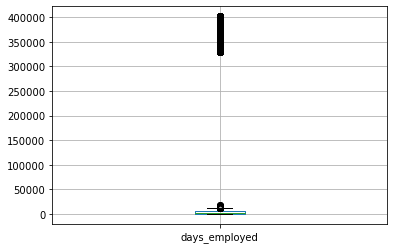

In [48]:
df.boxplot('days_employed') #Посмотрим на распределние значений через боксплот
plt.show()

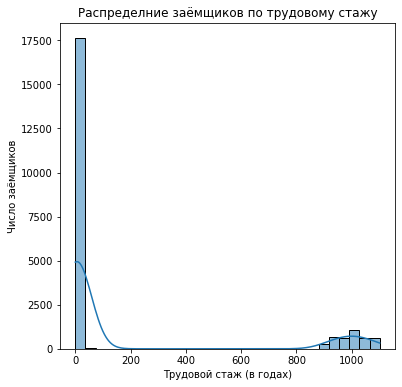

In [49]:
 #Более подробно рассмотрим гистограмму
plt.figure(figsize=(6,6))
ax_1 = sns.histplot(data=years_employed, bins=30, kde=True)
plt.ylabel('Число заёмщиков')
plt.xlabel('Трудовой стаж (в годах)')
ax_1.axes.set_title('Распределние заёмщиков по трудовому стажу', fontsize=12)
plt.show()

Есть большой "остров" аномалий в районе тысячи лет стажа 

Взглянем на распределение аномалий

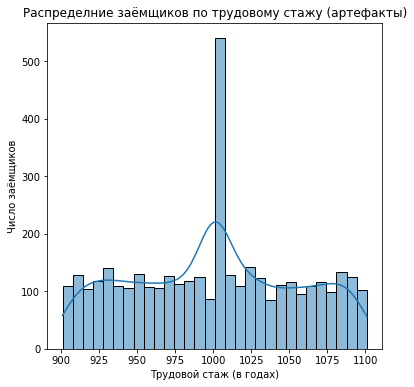

Количество строк в аномальном участке 3858


In [50]:
years_employed = round(df['days_employed'] / 365).astype(int)
plt.figure(figsize=(6,6))
ax_1 = sns.histplot(data=years_employed[years_employed > 50], bins=30, kde=True)
plt.ylabel('Число заёмщиков')
plt.xlabel('Трудовой стаж (в годах)')
ax_1.axes.set_title('Распределние заёмщиков по трудовому стажу (артефакты)', fontsize=12)
plt.show()
print(f'Количество строк в аномальном участке {years_employed[years_employed > 50].count()}')

И распределение "нормального" участка

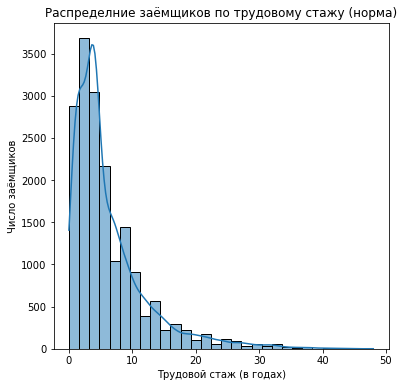

Количество строк в нормальном участке 17665


In [51]:
years_employed = round(df['days_employed'] / 365).astype(int)
years_employed_without_mstk = years_employed[years_employed < 50]
plt.figure(figsize=(6,6))
ax_1 = sns.histplot(data=years_employed_without_mstk, bins=30, kde=True)
plt.ylabel('Число заёмщиков')
plt.xlabel('Трудовой стаж (в годах)')
ax_1.axes.set_title('Распределние заёмщиков по трудовому стажу (норма)', fontsize=12)
plt.show()
print(f'Количество строк в нормальном участке {years_employed[years_employed < 50].count()}')

In [69]:
df['days_employed'].loc[df['days_employed'] > 67302.111829] = np.nan #Всё выше среднего числа заменил на nan
df['days_employed'].describe()

count    17666.000000
mean      2283.457659
std       2198.476789
min         24.000000
25%        843.250000
50%       1574.000000
75%       2939.750000
max      18388.000000
Name: days_employed, dtype: float64

### Лемматизация

Проведём в purpose лемматизацию что бы свести назначения кредита к каким-то единым категориям

In [54]:
uniq_purpose = df['purpose'].unique() # Для экономии ресурсов вместо лемматизации всего столбца - прмиеним лемматизацию
lemmed_purpose = [] # уникальных значений, создадим список {оригинал:лемматизированное значение} и по ключу подставим нужные
for val in uniq_purpose:
    lemmed_purpose.append(m.lemmatize(val))
not_lemmed_and_lemmed = dict(zip(uniq_purpose, lemmed_purpose))

In [55]:
for val in lemmed_purpose: print(val)

['покупка', ' ', 'жилье', '\n']
['приобретение', ' ', 'автомобиль', '\n']
['дополнительный', ' ', 'образование', '\n']
['сыграть', ' ', 'свадьба', '\n']
['операция', ' ', 'с', ' ', 'жилье', '\n']
['образование', '\n']
['на', ' ', 'проведение', ' ', 'свадьба', '\n']
['покупка', ' ', 'жилье', ' ', 'для', ' ', 'семья', '\n']
['покупка', ' ', 'недвижимость', '\n']
['покупка', ' ', 'коммерческий', ' ', 'недвижимость', '\n']
['покупка', ' ', 'жилой', ' ', 'недвижимость', '\n']
['строительство', ' ', 'собственный', ' ', 'недвижимость', '\n']
['недвижимость', '\n']
['строительство', ' ', 'недвижимость', '\n']
['на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', '\n']
['на', ' ', 'покупка', ' ', 'свой', ' ', 'автомобиль', '\n']
['операция', ' ', 'с', ' ', 'коммерческий', ' ', 'недвижимость', '\n']
['строительство', ' ', 'жилой', ' ', 'недвижимость', '\n']
['жилье', '\n']
['операция', ' ', 'со', ' ', 'свой', ' ', 'недвижимость', '\n']
['автомобиль', '\n']
['заниматься', ' ', 'образование'

In [56]:
def creating_of_lemmedcol(row):
    return not_lemmed_and_lemmed[row]
df['shorted_purpose'] = df['purpose'].apply(creating_of_lemmedcol)

Разобьём все цели на 4 основных категории - образование, автомобиль, свадьба, недвижимость(жильё)

In [57]:
def shorted_lemmas(row):
    if 'автомобиль' in row:
        return 'автомобиль'
    elif 'образование' in row:
        return 'образование'
    elif 'свадьба' in row:
        return 'свадьба'
    elif 'жилье' or 'недвижимость' in row:
        return 'недвижимость'
df['shorted_purpose'] = df['shorted_purpose'].apply(shorted_lemmas)
display(df['shorted_purpose'].value_counts())

недвижимость    10839
автомобиль       4315
образование      4022
свадьба          2348
Name: shorted_purpose, dtype: int64

### Категоризация данных

Зададим столбцу с доходами категории на основе квартилей

In [58]:
print(df['total_income'].describe())

count    2.152400e+04
mean     1.652093e+05
std      9.801952e+04
min      2.066700e+04
25%      1.077958e+05
50%      1.425940e+05
75%      1.955445e+05
max      2.265604e+06
Name: total_income, dtype: float64


Задам категории для уровня дохода и выделю их в отдельный столбец

In [90]:
def ti_category(row):
    if row <= 1.077958e+05:
        return 'низкий доход'
    elif row <= 1.425940e+05:
        return 'средний доход'
    elif row <= 1.955445e+05:
        return 'высокий доход'
    elif row >= 1.955445e+05:
        return 'сверхвысокий доход'
df['total_income_category'] = df['total_income'].apply(ti_category)
df['total_income_category'].value_counts()

средний доход         5524
сверхвысокий доход    5381
низкий доход          5381
высокий доход         5238
Name: total_income_category, dtype: int64

**Вывод**

Почистив датасет от артефактов, отлемматизировав назначение кредита и проделав прочую предобработку подготовили данные к дальнейшему анализу

In [60]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,shorted_purpose,total_income_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,недвижимость,сверхвысокий доход
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль,средний доход
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,недвижимость,высокий доход
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование,сверхвысокий доход
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба,высокий доход
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,недвижимость,сверхвысокий доход
21521,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,автомобиль,высокий доход
21522,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,недвижимость,низкий доход
21523,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,автомобиль,сверхвысокий доход


## Анализ датасета

Рассмотрим информацию касаемо семейного положения и семьи заёмщика в целом

In [61]:
child_pivot = df.pivot_table(index = 'children', values='debt', aggfunc=['sum', 'count', 'mean'])
display(child_pivot) # Составим общую таблицу по детям 
fam_pivot = df.pivot_table(index = 'family_status', values='debt', aggfunc=['sum', 'count', 'mean'])
display(fam_pivot) # И по семейному положению 

,sum,count,mean
,debt,debt,debt
children,,,
0,1063,14148,0.075134
1,445,4865,0.091470
2,202,2131,0.094791
3,27,330,0.081818
4,4,41,0.097561
5,0,9,0.000000


,sum,count,mean
,debt,debt,debt
family_status,,,
Не женат / не замужем,274,2813,0.097405
в разводе,85,1195,0.071130
вдовец / вдова,63,960,0.065625
гражданский брак,388,4177,0.092890
женат / замужем,931,12379,0.075208


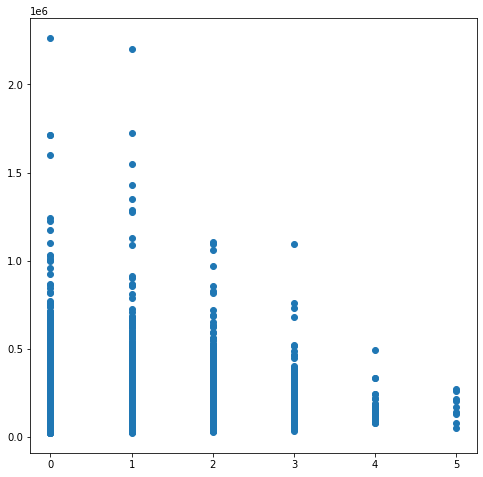

In [62]:
x = df['children']
y = df['total_income']
fig,ax = plt.subplots(figsize = (8,8))
ax.scatter(x, y)

**Вывод**

Пояснение к таблице: \
В столбце sum - число должников, в count - общее число людей в категории, mean - процент должников от общей суммы, выраженный в виде вещественного числа(чем числоближе к единице, тем больший процент должников в категории)
Из аналаза видно следующее: \
Лучшие показатели по возврату у заёмщиков без детей и с 5 детьми. Но так как количтесво займщиков с 5 детьми крайне мало относительно общей таблицы это можно списать на погрешность. Для более точного результата необходимо больше данных 

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [63]:
income_pivot = df.pivot_table(index = 'total_income_category', values='debt', aggfunc=['sum', 'count', 'mean'])
display(income_pivot)

,sum,count,mean
,debt,debt,debt
total_income_category,,,
высокий доход,543,6343,0.085606
низкий доход,427,5381,0.079353
сверхвысокий доход,386,5381,0.071734
средний доход,385,4419,0.087124


**Вывод**

Из аналази видно следующее: \
Лучшая ситуация сложилась в категории сверхвысокого дохода. Немногим хуже - в категории низкого дохода. Две средние группы имеют примерно одинаковое значение

- Как разные цели кредита влияют на его возврат в срок?

Применим функцию, аналогичную предыдущей

In [64]:
purpose_pivot = df.pivot_table(index = 'shorted_purpose', values='debt', aggfunc=['sum', 'count', 'mean'])
display(purpose_pivot)

,sum,count,mean
,debt,debt,debt
shorted_purpose,,,
автомобиль,403,4315,0.093395
недвижимость,782,10839,0.072147
образование,370,4022,0.091994
свадьба,186,2348,0.079216


**Вывод**

Из анализа видно следующее: \
Хуже всего возвращают кредиты на авто. Чуть лучше - на образование. И достаточно хорошая ситуация сложилась с категорией недвижимости и свадеб.

## Шаг 4. Общий вывод

Из общего анализа можно сделать следующий вывод: \
Целесообразнее всего выдавать кредит людям без детей, состоящим в официальном браке, со сверхвысоким или низким доходом, на недвижимость или свадьбу. У такой категории шанс вернуть кредит вовремя выше всего